In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
from utils import loadSequential, loadTabular, getDataloaders, train, dumpSubmission
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
data, labels = loadTabular(cleaned=True)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lin_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lin_input = nn.Linear(hidden_size, lin_size)
        self.lin_output = nn.Linear(lin_size, output_size)
        self.soft = nn.Softmax(dim=1)
    
    def forward(self, sequence):
        hidden_cell = (torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double),
                        torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double))
        lstm_out, _ = self.lstm(sequence, hidden_cell)
        output = F.hardswish(self.lin_input(lstm_out[:, -1, :]))
        output = self.soft(self.lin_output(output))
        return output

In [4]:
model = LSTM(9, 16, 2, 32, 6).double()

In [5]:
sequences = loadSequential()
train_dataloader, test_dataloader = getDataloaders(sequences, labels, batch_size=100)

epoch: 510 time: 3781.45
Loss: 1.2254517330683337 accuracy: 0.8188248095756256


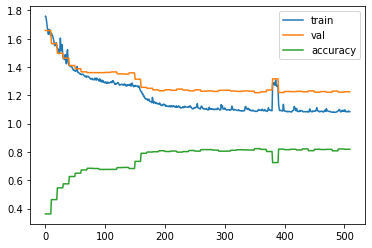

KeyboardInterrupt: 

In [11]:
train(model, train_dataloader, test_dataloader, 100, show_every=10)

In [12]:
test_seq = loadSequential(isTest=True)
test_seq = torch.from_numpy(test_seq).type(torch.double)
pred = model(test_seq)

tensor([[1.5166e-22, 3.5143e-22, 6.5028e-07, 5.7337e-04, 3.7095e-01, 6.2847e-01],
        [4.2858e-21, 5.4723e-19, 1.0676e-09, 3.2172e-09, 1.0000e+00, 4.7295e-09],
        [1.3677e-22, 1.0689e-23, 2.5054e-11, 3.2994e-10, 2.8906e-03, 9.9711e-01],
        ...,
        [3.8398e-08, 1.0000e+00, 8.7123e-08, 1.1771e-20, 2.0767e-13, 5.3863e-14],
        [8.1129e-07, 9.9999e-01, 6.1450e-06, 1.0750e-18, 1.4956e-10, 1.9350e-12],
        [1.8721e-05, 9.9998e-01, 7.6694e-07, 1.0408e-21, 4.5561e-12, 6.2788e-14]],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)

In [14]:
ans = np.array(pred.max(1)[1])
ans += 1

In [18]:
dumpSubmission(ans, 'seq_sub.csv')

(array([2, 3, 4, 5, 6, 7], dtype=int64),
 array([480, 440, 430, 532, 573, 492], dtype=int64))